In [42]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import dlib

In [95]:
frame = cv2.imread('../Sample_Pic_OD/HJ.jpg')
protoFile = "../caffemodels/pose_deploy_linevec.prototxt"
weightFile = "../caffemodels/pose_iter_440000.caffemodel"
faceHarr = cv2.CascadeClassifier('../harrs/haarcascade_frontalface_default.xml')
network = cv2.dnn.readNetFromCaffe(protoFile, weightFile)

def getSkeleton(frame, network, face_cascade, isHarr=False):
    ### Inferencing Pose ###
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],\
                  [6,7],[1,8],[8,9],[9,10], [14,11], [11,12], [12,13] ]
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
            "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
            "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
            "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
    idx_2_BODY_PARTS = {int(num):part for part, num in BODY_PARTS.items()}
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    
    # inHeight / inWidth
    inWidth = 368
    inHeight = 368
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0/255, (inWidth, inHeight),\
                                   (0,0,0), swapRB=False, crop=False)
    
    dotsize = int((frameWidth + frameHeight) / (inWidth))
    textsize = int((frameWidth + frameHeight) / (inWidth * 4))
    
    network.setInput(inpBlob)
    
    output = network.forward()
    H = output.shape[2]
    W = output.shape[3]
    
    points = []
    points_with_num = []
    facelist = []
    
    ### Inferencing face & emotion ###
    if isHarr:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        facelist = face_cascade.detectMultiScale(gray, 1.3, 5)
        facelist = list(np.array(facelist).flatten())
    else:
        import dlib
        hogFaceDetector = dlib.get_frontal_face_detector()
        faceRects = hogFaceDetector(frame, 0)
        facelist = [faceRects[0].left(),faceRects[0].top(),\
                                              faceRects[0].right()-faceRects[0].left(), faceRects[0].bottom()-faceRects[0].top()]
    
    emotion = None
    print(facelist)
    if len(facelist)!=0:
        (x,y,w,h) = facelist
        face = cv2.cvtColor(frame[x:x+w, y:y+h], cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, dsize=(48, 48), interpolation=cv2.INTER_LINEAR)
        input_face= face.reshape(-1,48,48,1)
        model = load_model()

        label_dict = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
        label_dict = {num:emotion for emotion, num in label_dict.items()}
        emotion = label_dict[np.argmax(model.predict(input_face))]
    
    ### Draw points, lines, rectangle ###
    ### Pose estimation ###
    for i in range(nPoints):
        # confidence map of corresponding body's part
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        
        if prob > threshold:
            cv2.circle(frameCopy, (int(x), int(y)), dotsize, (0,255,255),\
                      thickness=dotsize, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)),\
                       cv2.FONT_HERSHEY_SIMPLEX, textsize, (0,0,255), textsize, \
                       lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), dotsize, (0, 0, 255),\
                       thickness=dotsize, lineType=cv2.FILLED)
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
            points_with_num.append((int(x), int(y), int(i), idx_2_BODY_PARTS[int(i)]))
        else:
            points.append(None)
    
    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0,255,255), 3)
    
    ### Draw Face box and emotion ###
    if len(facelist)!=0:
        cv2.rectangle(frame, (x,x+w),(y,y+h),(0,255,255), 3)
        cv2.rectangle(frameCopy, (x,x+w),(y,y+h),(0,255,255), 3)
    
    img_skeleton = frame
    img_with_dot = frameCopy
    return img_skeleton, img_with_dot, points_with_num, emotion
    

In [ ]:
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)

[1189, 1066, 206, 206]


### Keras NN model

In [70]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1

In [59]:
def load_model(weight_path='../emotion_detector_models/model_v6_71+83.hdf5'):
    # Create the model
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
    # model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # # model.add(BatchNormalization())

    model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    # model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Activation("softmax"))
    
    model.load_weights(weight_path)
    
    return model

### Test

In [71]:
# import tensorflow as tf

# config = tf.ConfigProto()

# config.gpu_options.allow_growth = True

# sess = tf.Session(config=config)

img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)

[]


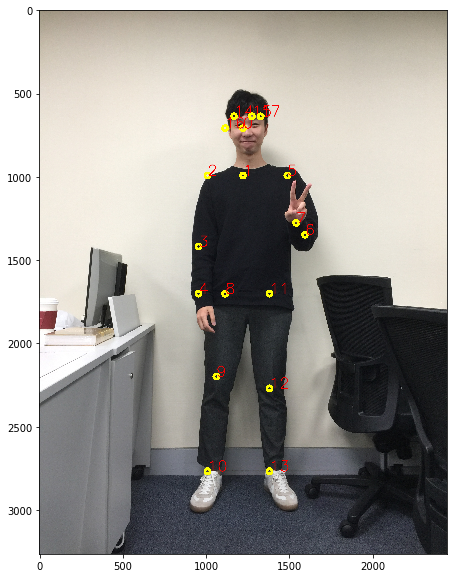

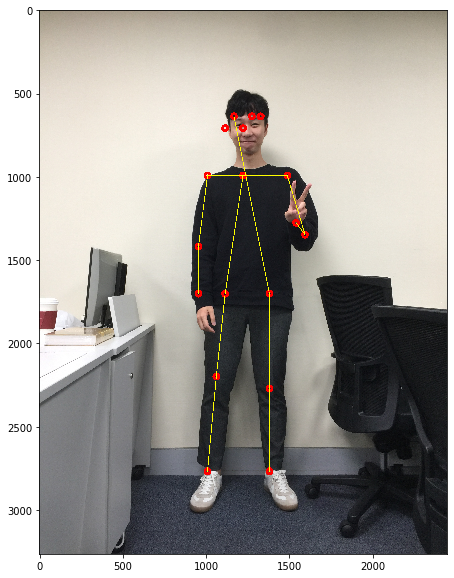

In [72]:
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))

In [73]:
print(emotion)

None


Fear


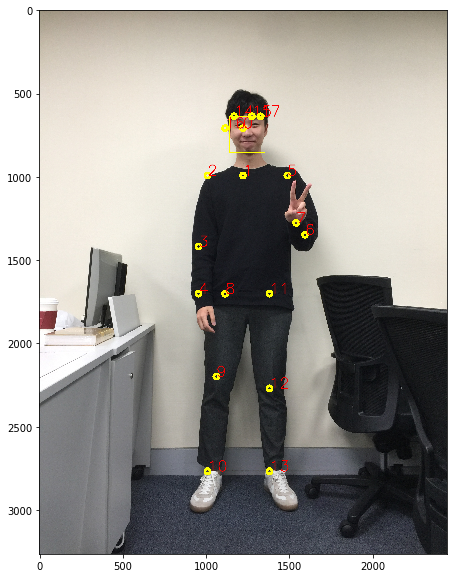

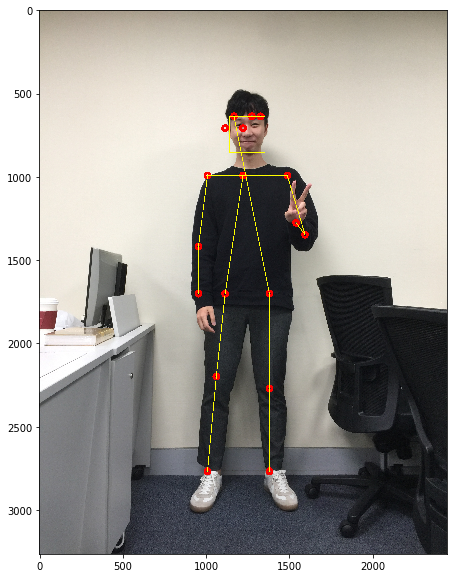

In [36]:
frame = cv2.imread('../Sample_Pic_OD/YK.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)

Happy


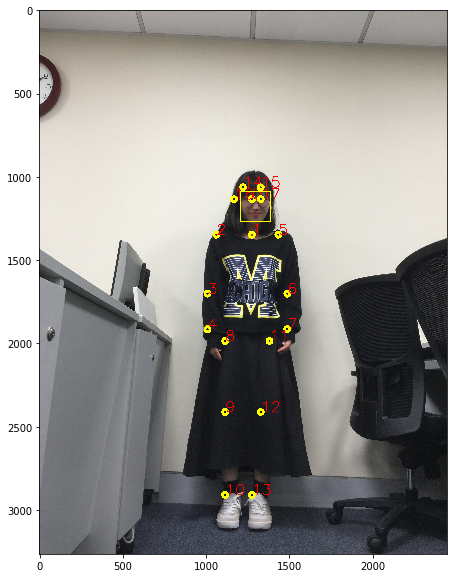

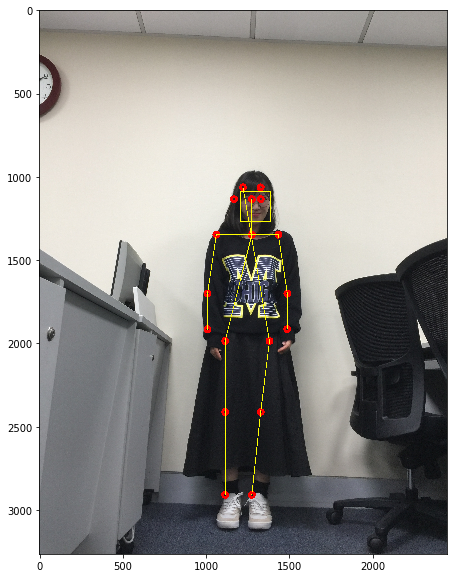

In [37]:
frame = cv2.imread('../Sample_Pic_OD/YJ.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)

Fear


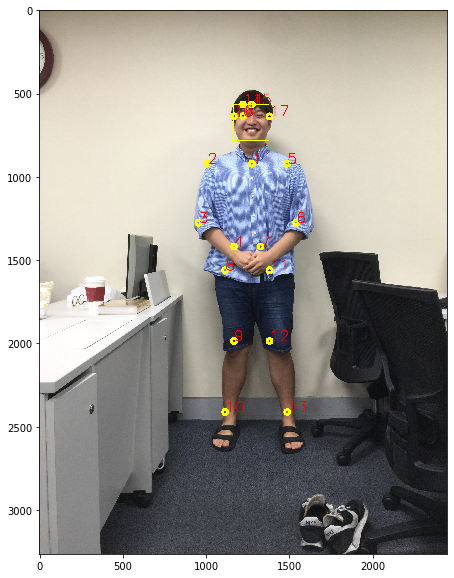

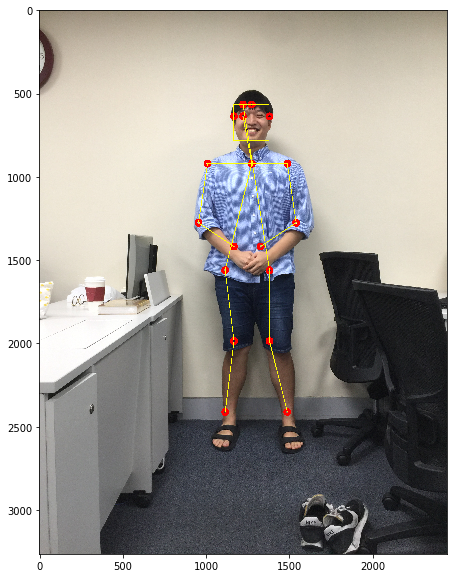

In [38]:
frame = cv2.imread('../Sample_Pic_OD/TH.jpg')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)

None


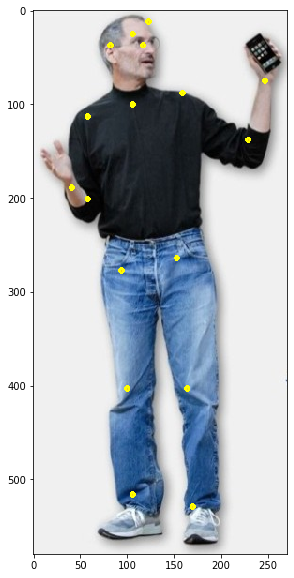

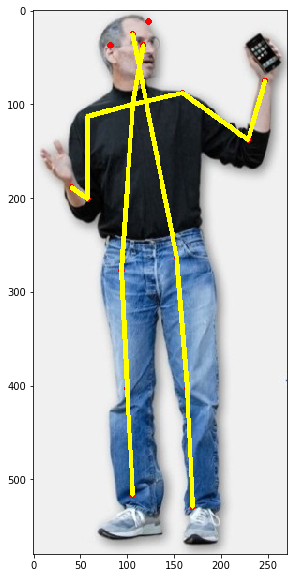

In [41]:
frame = cv2.imread('../Sample_Pic_OD/SJ.PNG')
img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)